In [1]:
import sys
print(sys.executable)
!pip install seaborn
!pip install missingno


c:\Users\paulm\AppData\Local\Programs\Python\Python39\python.exe



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

## I.Import des données ##

In [3]:
# Nettoyage manuel des espaces multiples dans le fichier
file_path = '..\data\welddb\welddb.data'
with open(file_path, 'r') as file:
    cleaned_lines = [' '.join(line.split()) for line in file]

# Conversion des lignes nettoyées en DataFrame

data = pd.read_csv(StringIO('\n'.join(cleaned_lines)), sep=' ', na_values='N',header=None)


In [4]:
# La taille du dataset
print("Le nombre de lignes est: " + str(data.shape[0]))
print("Le nombre de colonnes est: " + str(data.shape[1]))

Le nombre de lignes est: 1652
Le nombre de colonnes est: 44


In [5]:
columns = [
    "Carbon concentration / (weight%)",
    "Silicon concentration / (weight%)",
    "Manganese concentration / (weight%)",
    "Sulphur concentration / (weight%)",
    "Phosphorus concentration / (weight%)",
    "Nickel concentration / (weight%)",
    "Chromium concentration / (weight%)",
    "Molybdenum concentration / (weight%)",
    "Vanadium concentration / (weight%)",
    "Copper concentration / (weight%)",
    "Cobalt concentration / (weight%)",
    "Tungsten concentration / (weight%)",
    "Oxygen concentration / parts per million by weight",
    "Titanium concentration / parts per million by weight",
    "Nitrogen concentration / parts per million by weight",
    "Aluminium concentration / parts per million by weight",
    "Boron concentration / parts per million by weight",
    "Niobium concentration / parts per million by weight",
    "Tin concentration / parts per million by weight",
    "Arsenic concentration / parts per million by weight",
    "Antimony concentration / parts per million by weight",
    "Current / A",
    "Voltage / V",
    "AC or DC",
    "Electrode positive or negative",
    "Heat input / kJ/mm",
    "Interpass temperature / deg C",
    "Type of weld",
    "Post weld heat treatment temperature / deg C",
    "Post weld heat treatment time / hours",
    "Yield strength / MPa",
    "Ultimate tensile strength / MPa",
    "Elongation / %",
    "Reduction of Area / %",
    "Charpy temperature / deg C",
    "Charpy impact toughness / J",
    "Hardness / kg/mm2",
    "50 % FATT",
    "Primary ferrite in microstructure / %",
    "Ferrite with second phase / %",
    "Acicular ferrite / %",
    "Martensite / %",
    "Ferrite with carbide aggregate / %",
    "Weld ID"
]

In [6]:
data.columns=columns
data.head()

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy temperature / deg C,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


## II.Groupement ID ##

In [7]:
# Exemple de DataFrame avec une colonne d'identifiants
data_exple = {
    'ID': ['abcd123', 'abc124', 'abcd125', 'def456', 'def457', 'ghi789', 'ghi7abc']
}

df_exple = pd.DataFrame(data_exple)

# Fonction pour trouver le plus long préfixe commun
def find_longest_common_prefix(ids):
    if not ids:
        return ""
    
    prefix = ids[0]  # Commencer avec le premier identifiant
    for id in ids[1:]:
        while not id.startswith(prefix) and prefix:  # Réduire le préfixe jusqu'à ce qu'il corresponde
            prefix = prefix[:-1]
    return prefix

# Appliquer la fonction à chaque identifiant pour déterminer le préfixe commun
def get_common_prefix(current_id, ids):
    # Chercher le préfixe commun uniquement parmi ceux qui partagent un préfixe similaire
    return find_longest_common_prefix([id for id in ids if id.startswith(current_id[:3])])

# Appliquer la fonction pour chaque ID
df_exple['Common_Prefix'] = df_exple['ID'].apply(lambda x: get_common_prefix(x, df_exple['ID'].tolist()))

df_exple

,ID,Common_Prefix
0,abcd123,abc
1,abc124,abc
2,abcd125,abc
3,def456,def45
4,def457,def45
5,ghi789,ghi7
6,ghi7abc,ghi7


In [8]:
data['Common_Prefix'] = data['Weld ID'].apply(lambda x: get_common_prefix(x, data['Weld ID'].tolist()))
data['Common_Prefix'].value_counts()

Evans                      856
SvenGret-1990-              96
Pat-1981-                   79
Mart-                       70
Gar&K-1975-                 56
PantK-1990-                 54
Cunh-1982-                  38
EvHtIp1979-                 32
Wolst-1974-                 32
Icici&-1992-                30
Chandel&-1985W              23
KocakP                      21
Ditt-                       20
RaiterGonzal-Mo-1989-       18
Blond&-1984-                18
PakSven-1990-               17
Hunt&-Di-1994-              16
JorgeEtAl-1993-             16
Stil-TiB-1978-              16
Wats-1981-                  12
Kluket-CuMnB-1994-          12
EPRI-TR-101394s-E9          12
Es-Souni&-Cu/CMn-1990-      12
Ga&K-1975II-                10
Birmingham-MAX3              9
SurianEtAl-C-1991-0.         8
Alekseev&-CMnNi-1991-CH      7
Sw&Rog-1973                  4
Natsume-1990-                4
RC81033                      4
p25-RR82011                  2
p36-RR82011                  2
p35-RR82

In [9]:
# df_pivot= pd.pivot_table(df,values=['colonne1',...],index=,aggfunc={'colonne1':"mean",...})

## Remarque sur les variables cibles : 
- Hardness / kg/mm² : Une mesure de la dureté du matériau soudé, qui est souvent liée à la qualité de la soudure.
- Yield strength / MPa ou Ultimate tensile strength / MPa : Ces deux mesures de résistance pourraient également servir de variable cible, car elles reflètent la capacité du matériau à résister à la déformation ou à la rupture.
- Elongation / etou Reduction of Area / % : Ces mesures sont souvent utilisées pour évaluer la ductilité et la ténacité d'un matériau, ce qui peut être pertinent pour la qualité des soudure##

## Petit nettoyage ##

In [10]:
# Fonction pour nettoyer les valeurs dans les colonnes numériques
def clean_numeric_values(value):
    if isinstance(value, str) and '<' in value:
        # Enlève le symbole '<' et convertit en float
        return float(value.replace('<', '').strip())
        # If it's a string that might contain numbers and other characters
    if isinstance(value, str):
        # Use regex to find the first sequence of digits in the string
        match = re.match(r'\d+', value)
        if match:
            return float(match.group()) 
    try:
        # Essaye de convertir la valeur en float directement
        return float(value)
    except (ValueError, TypeError):
        # Si la conversion échoue (ex. si c'est une chaîne non numérique), retourne la valeur originale
        return value

# Appliquer la fonction uniquement aux 21 premières colonnes
data.iloc[:, :21] = data.iloc[:, :21].applymap(clean_numeric_values)
data.iloc[:, 36:37] = data.iloc[:, 36:37].applymap(clean_numeric_values)
data.iloc[:, 38:39] = data.iloc[:, 38:39].applymap(clean_numeric_values)

# Affichage des premières lignes du DataFrame nettoyé
data

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
0,0.037,0.30,0.65,0.0,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw,Evans
1,0.037,0.30,0.65,0.0,0.012,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch,Evans
2,0.037,0.30,0.65,0.0,0.012,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht,Evans
3,0.037,0.31,1.03,0.0,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw,Evans
4,0.037,0.31,1.03,0.0,0.014,0.00,NaN,NaN,NaN,NaN,...,100.0,NaN,NaN,32.0,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch,Evans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.0,0.016,0.60,8.6,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX35,Birmingham-MAX3
1648,0.088,0.36,0.88,0.0,0.017,0.57,8.4,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX36,Birmingham-MAX3
1649,0.090,0.34,0.89,0.0,0.016,0.17,8.2,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX37,Birmingham-MAX3
1650,0.092,0.35,0.90,0.0,0.016,0.54,8.4,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX38,Birmingham-MAX3


## III.Missing values ##

### III.Missing values : vision générale ###

In [11]:
data.isnull().sum()

Carbon concentration / (weight%)                            0
Silicon concentration / (weight%)                           0
Manganese concentration / (weight%)                         0
Sulphur concentration / (weight%)                           4
Phosphorus concentration / (weight%)                       10
Nickel concentration / (weight%)                          955
Chromium concentration / (weight%)                        868
Molybdenum concentration / (weight%)                      859
Vanadium concentration / (weight%)                        724
Copper concentration / (weight%)                         1074
Cobalt concentration / (weight%)                         1523
Tungsten concentration / (weight%)                       1577
Oxygen concentration / parts per million by weight        396
Titanium concentration / parts per million by weight      717
Nitrogen concentration / parts per million by weight      410
Aluminium concentration / parts per million by weight     747
Boron co

In [12]:
df=data

<AxesSubplot: >

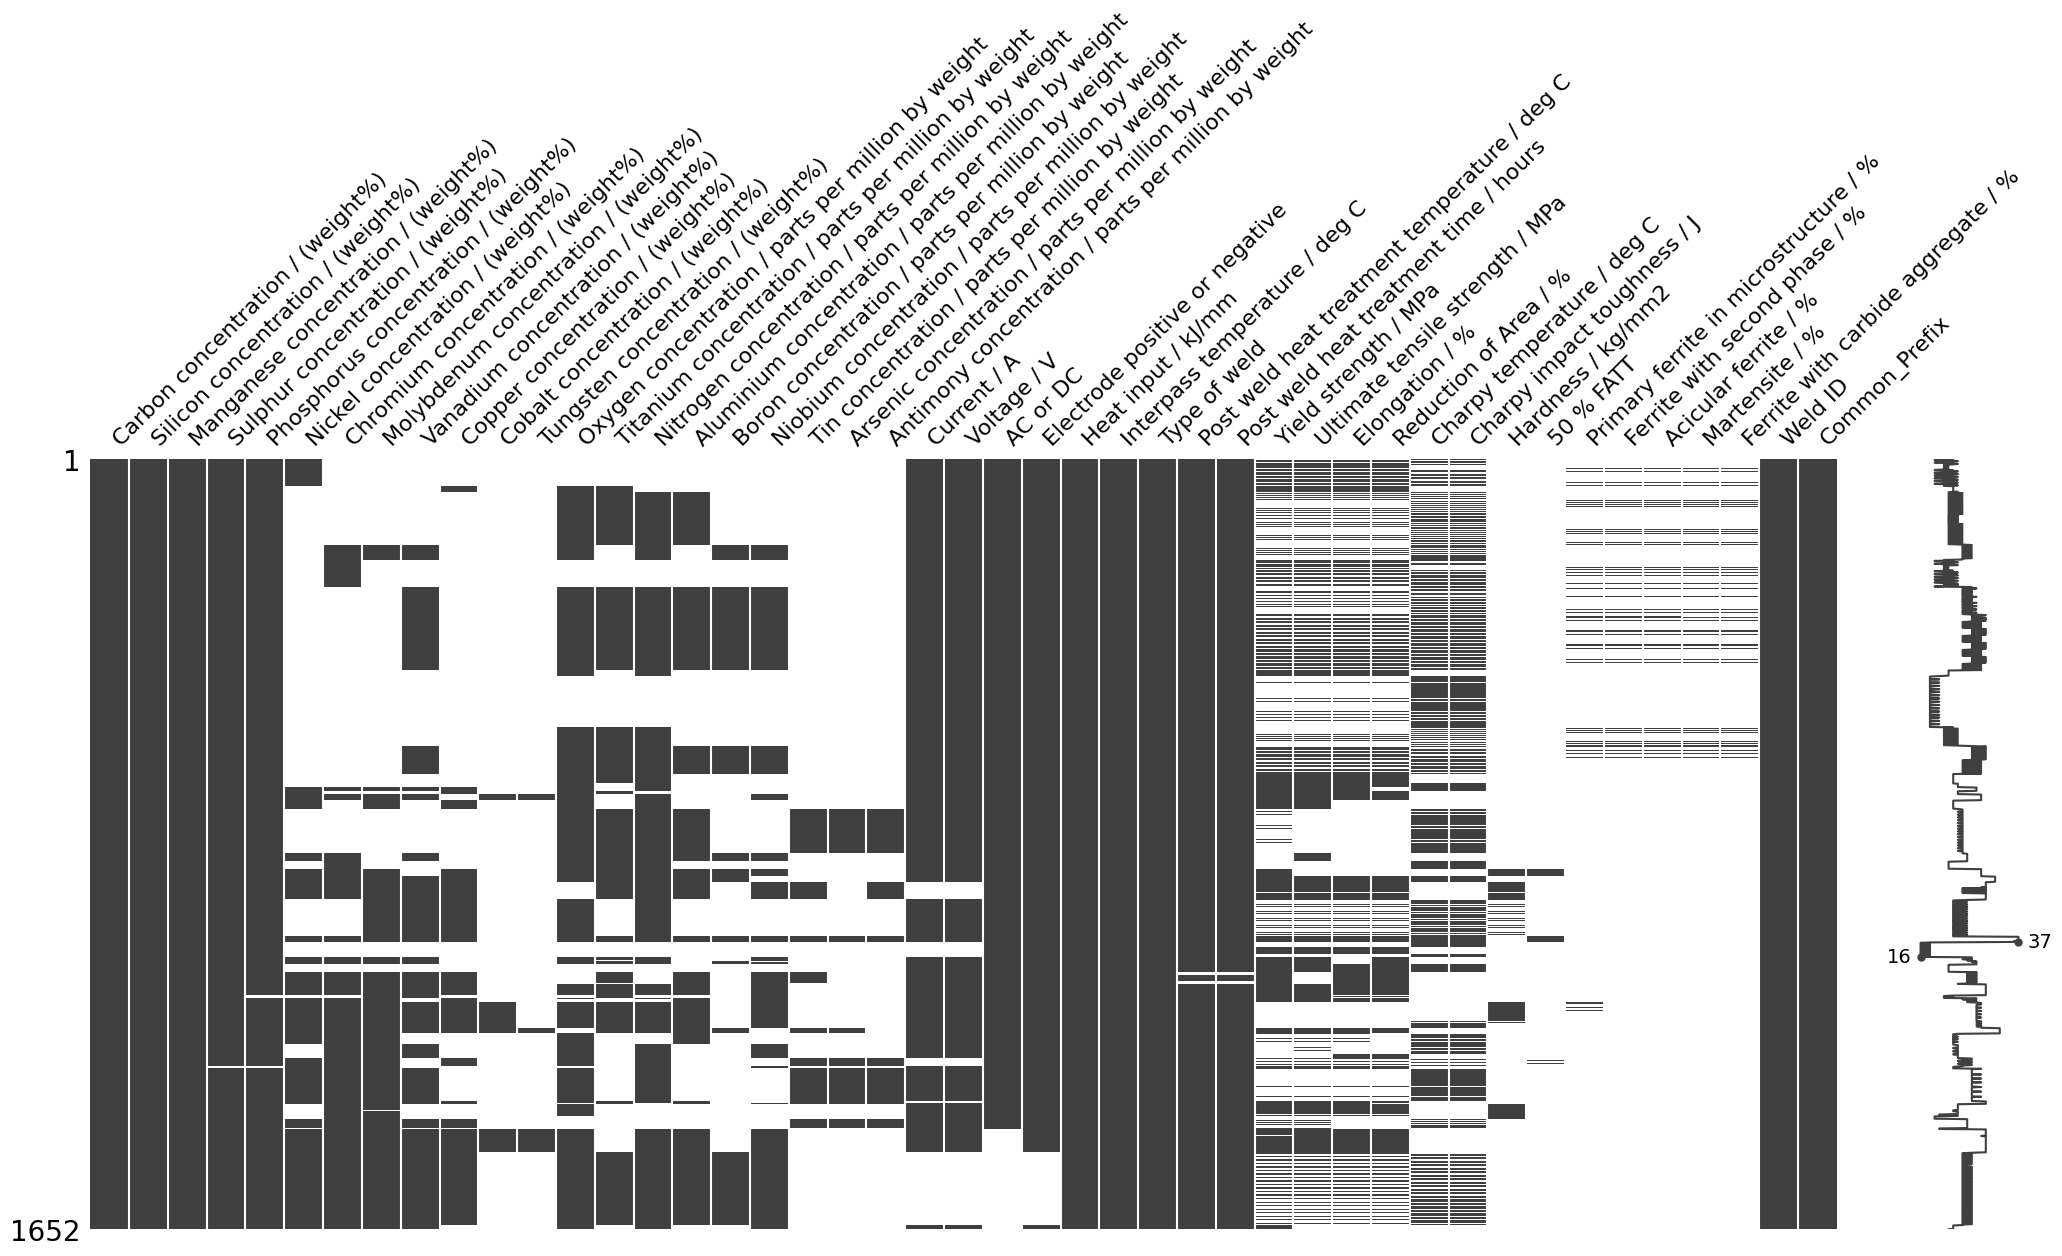

In [13]:
import missingno as msno
msno.matrix(df)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
non_numeric_columns = df.select_dtypes(exclude=['float64', 'int64']).columns

# Step 2: Apply KNN Imputation to numeric data
imputer = KNNImputer(n_neighbors=2)

# Impute only numeric columns
df_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)

# Step 3: Combine the imputed numeric columns with the non-numeric columns
df_combined = pd.concat([df_numeric, df[non_numeric_columns]], axis=1)


In [15]:
def repartition_valeurs(L):
    dico = {}
    for l in L:
        if l in dico:
            dico[l] += 1
        else:
            dico[l] = 1
    return dico

print(repartition_valeurs(df["Primary ferrite in microstructure / %"].tolist()))

{nan: 1, nan: 1, nan: 1, nan: 1, 32.0: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 13.0: 4, nan: 1, nan: 1, nan: 1, nan: 1, 19.0: 10, nan: 1, nan: 1, nan: 1, nan: 1, 8.0: 3, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 20.0: 4, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 6.0: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 16.0: 6, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 5.0: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 14.0: 3, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 0.0: 4, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 34.0: 2, nan: 1, nan: 1, nan: 1, 45.0: 2, nan: 1, nan: 1, nan: 1, 40.0: 1, nan: 1, nan: 1, nan: 1, 35.0: 2, nan: 1, nan: 1, nan: 1, 44.0: 1, nan: 1, nan: 1, nan: 1, 38.0: 1, nan: 1, nan: 1, nan: 1, 22.0: 4, nan: 1, nan: 1, nan: 1, 24.0: 5, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, 21.0: 5, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1,

<AxesSubplot: >

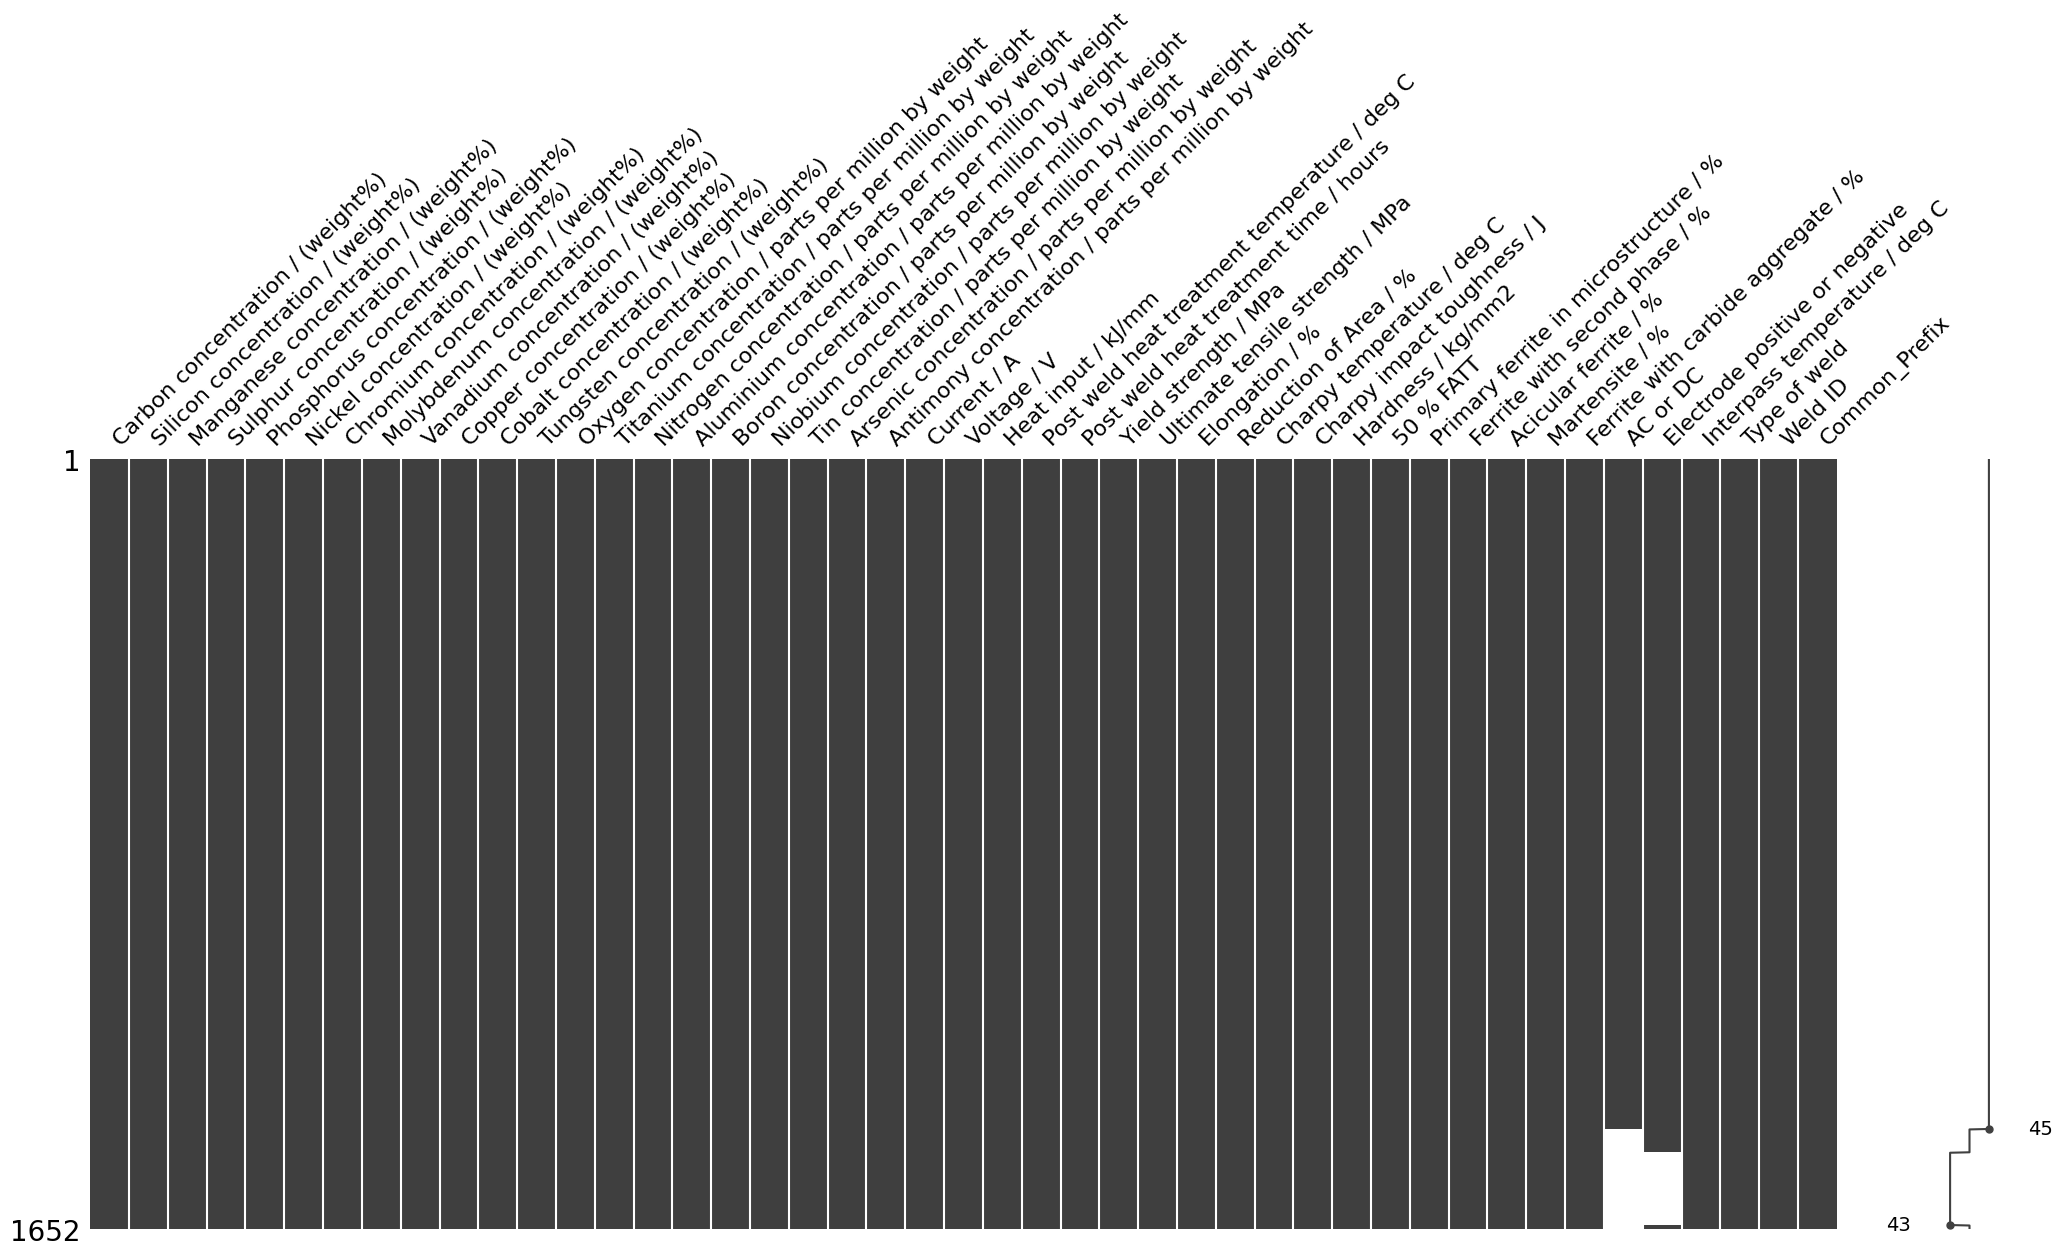

In [16]:
import missingno as msno
msno.matrix(df_combined)

# <font color="red">II.2 Trying to make clusters</font>

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Silhouette Score: 0.20543257793161457


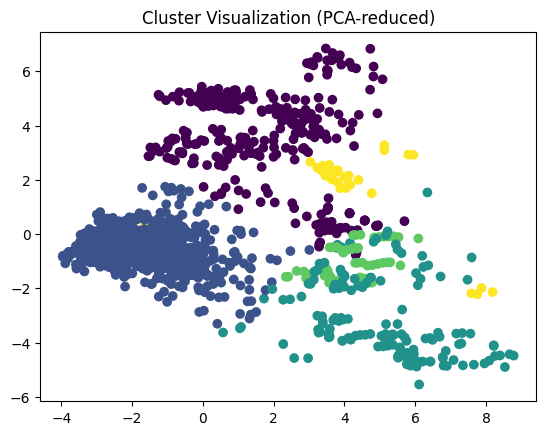

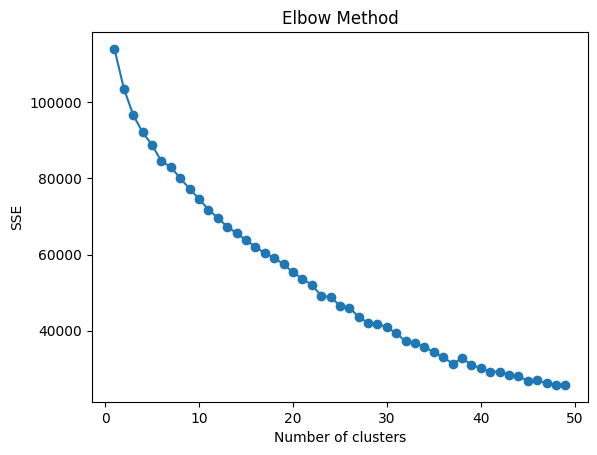

In [18]:
text_columns = ["AC or DC","Electrode positive or negative","Interpass temperature / deg C","Type of weld"]
df_text_encoded = pd.get_dummies(df[text_columns])
df_combined_no_text = pd.concat([df_combined[numeric_columns], df_text_encoded], axis=1)
# Scale the combined data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_combined_no_text)
# Define the number of clusters (k)
k = 5  # You can experiment with different values for k

# Apply K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# Add the cluster labels to your original dataframe
df['cluster'] = clusters
sil_score = silhouette_score(df_scaled, clusters)
print(f'Silhouette Score: {sil_score}')
# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Plot clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Cluster Visualization (PCA-reduced)')
plt.show()
sse = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.plot(range(1, 50), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Bloc pour savoir où lancer

### Conclusion

Compliqué de déterminer le paramètre optimal k + les clusters n'ont pas trop de sens (cluster réalisé avec toutes les colonnes)

Voir maintenant ce que ça donne si on enlève une ou plusieurs colonnes cibles



## TODO

y=
Yield strength / MPa                
Ultimate tensile strength / MPa     
Elongation / %                      
Reduction of Area / %               
Hardness / kg/mm2 

Faire un dataset de train/test
Refaire le kNN sur les X seulement
Puis faire une régression sur (X,y_i) puis un kNN pour faire le modèle


## Que faire ?

- Séparer les datasets avec un dataset de test global
- Compléter les missing values de X en utilisant des fit_transform et des transform sur respectivement le dataset d'entrainement et celui de test
    - Utiliser moyennes++ de Saad, un kNN...
- Faire une PCA
- Compléter les 5 y indépemment chacun, avec une régression, un kNN ou un autre modèle avec des datasets de test locaux
- Réaliser une inférence
- Faire un clustering
- Vérifier les métriques avec le dataset de test global

#### Remarque: Beaucoup de valeurs manquantes ####

### III.Missing values :  Sulphur concentration / (weight%) ###


In [13]:
data[data['Sulphur concentration / (weight%)'].isnull()]

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
1303,0.11,0.18,0.70,NaN,NaN,0.13,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hl,Natsume-1990-
1304,0.10,0.17,0.67,NaN,NaN,0.14,2.31,0.29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hh,Natsume-1990-
1305,0.11,0.17,0.65,NaN,NaN,0.02,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-ll,Natsume-1990-
1306,0.10,0.16,0.61,NaN,NaN,0.02,2.27,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-lh,Natsume-1990-


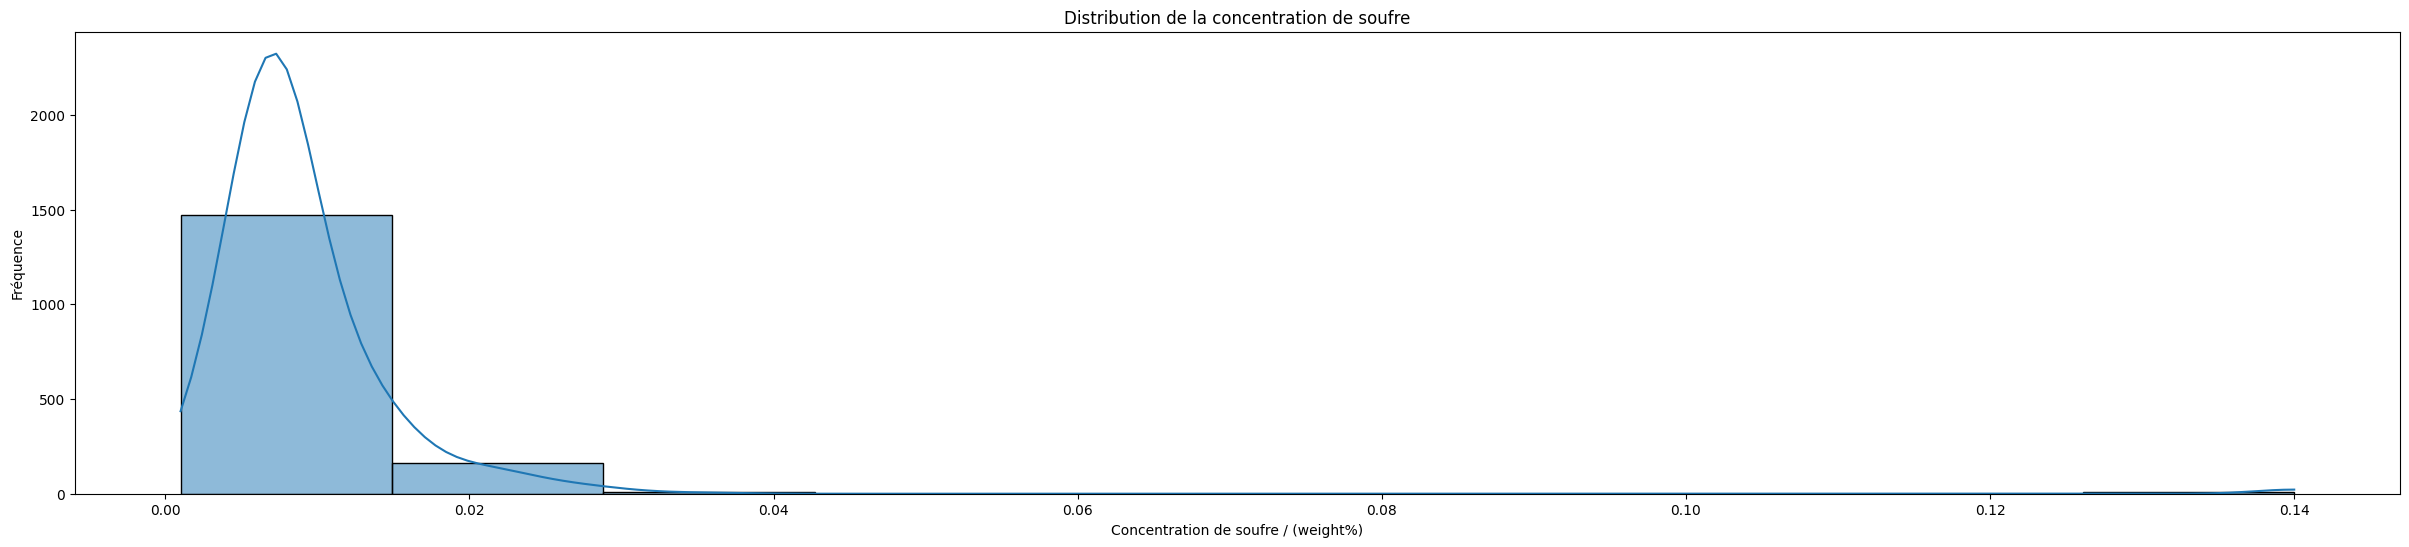

In [14]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(data['Sulphur concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de soufre')
plt.xlabel('Concentration de soufre / (weight%)')
plt.ylabel('Fréquence')
plt.show()

In [15]:
df['Sulphur concentration / (weight%)'].fillna(df['Sulphur concentration / (weight%)'].mean(), inplace=True)

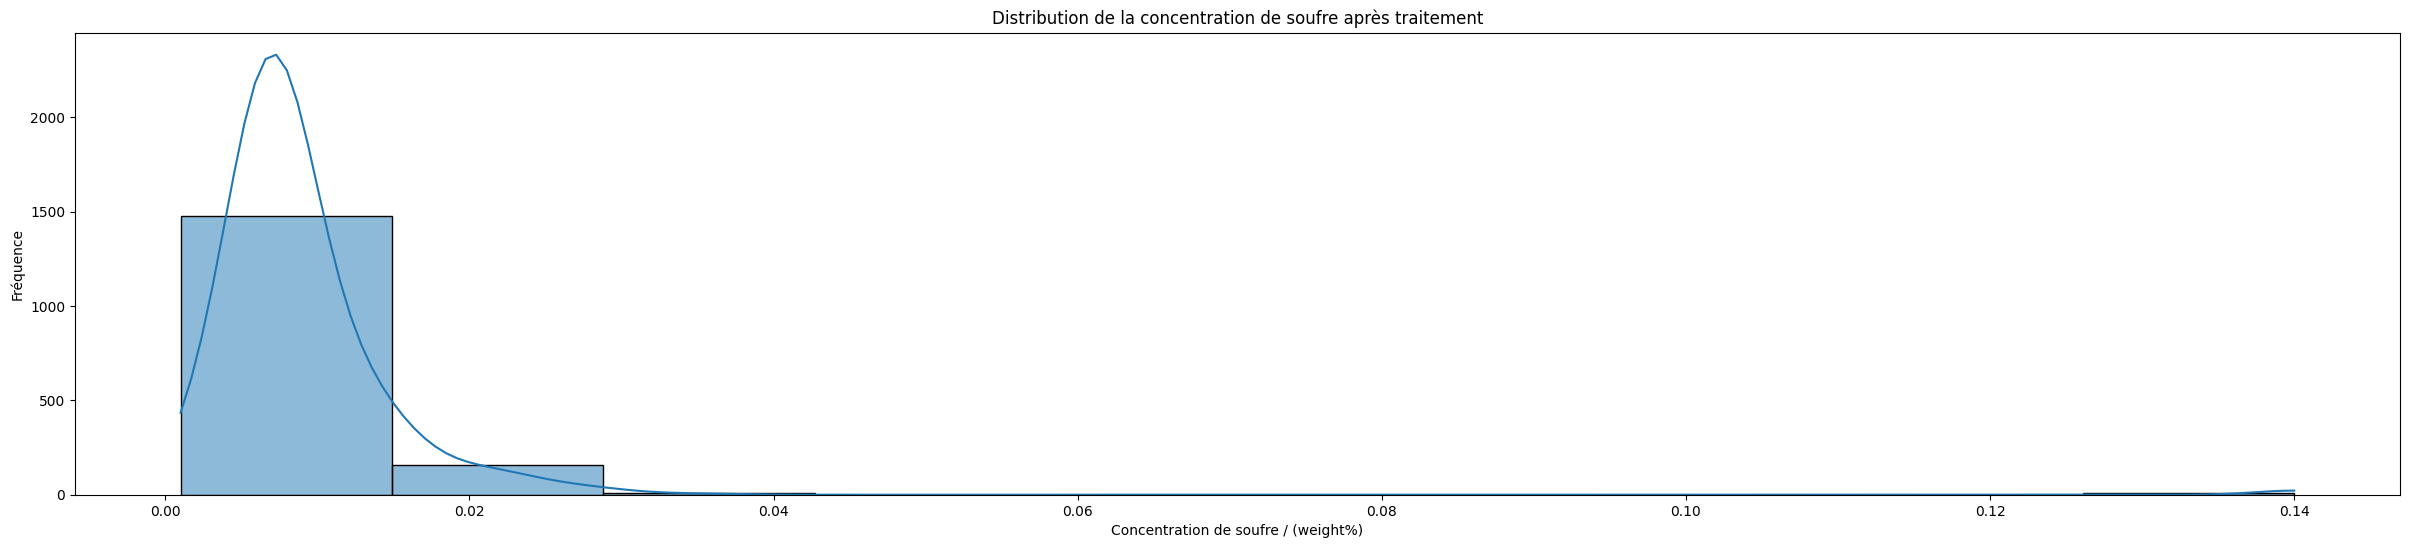

In [16]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(data['Sulphur concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de soufre après traitement')
plt.xlabel('Concentration de soufre / (weight%)')
plt.ylabel('Fréquence')
plt.show()


### III.Missing values :  Phosphorus concentration / (weight%) ###

In [17]:
df['Phosphorus concentration / (weight%)'].describe()

count    1642.000000
mean        0.012952
std         0.019627
min         0.002000
25%         0.007000
50%         0.010000
75%         0.014000
max         0.250000
Name: Phosphorus concentration / (weight%), dtype: float64

In [18]:
df[df['Phosphorus concentration / (weight%)'].isnull()]

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy impact toughness / J,Hardness / kg/mm2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggregate / %,Weld ID,Common_Prefix
1150,0.11,0.38,1.50,0.029000,NaN,NaN,NaN,0.00,0.005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-26aw,Gar&K-1975-
1151,0.11,0.37,1.52,0.030000,NaN,NaN,NaN,0.00,0.050,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-27aw,Gar&K-1975-
1152,0.11,0.38,1.55,0.029000,NaN,NaN,NaN,0.00,0.090,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-28aw,Gar&K-1975-
1153,0.14,0.38,1.65,0.028000,NaN,NaN,NaN,0.50,0.005,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-29aw,Gar&K-1975-
1154,0.10,0.38,1.58,0.028000,NaN,NaN,NaN,0.50,0.060,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-30aw,Gar&K-1975-
1155,0.10,0.39,1.68,0.027000,NaN,NaN,NaN,0.50,0.080,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gar&K-1975-12mmE-31aw,Gar&K-1975-
1303,0.11,0.18,0.70,0.009529,NaN,0.13,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hl,Natsume-1990-
1304,0.10,0.17,0.67,0.009529,NaN,0.14,2.31,0.29,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-hh,Natsume-1990-
1305,0.11,0.17,0.65,0.009529,NaN,0.02,2.28,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-ll,Natsume-1990-
1306,0.10,0.16,0.61,0.009529,NaN,0.02,2.27,0.27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Natsume-1990-lh,Natsume-1990-


In [19]:
m = df[df['Common_Prefix'] == 'Gar&K-1975-']['Phosphorus concentration / (weight%)'].mean()

In [20]:
# Fill NaN values with the mean in the original DataFrame
df.loc[df['Common_Prefix'] == 'Gar&K-1975-', 'Phosphorus concentration / (weight%)'] = df.loc[df['Common_Prefix'] == 'Gar&K-1975-', 'Phosphorus concentration / (weight%)'].fillna(m)

In [21]:
df['Phosphorus concentration / (weight%)'].fillna(df['Phosphorus concentration / (weight%)'].mean(), inplace=True)

### III.Missing values :  other concentrations / (weight%) ###

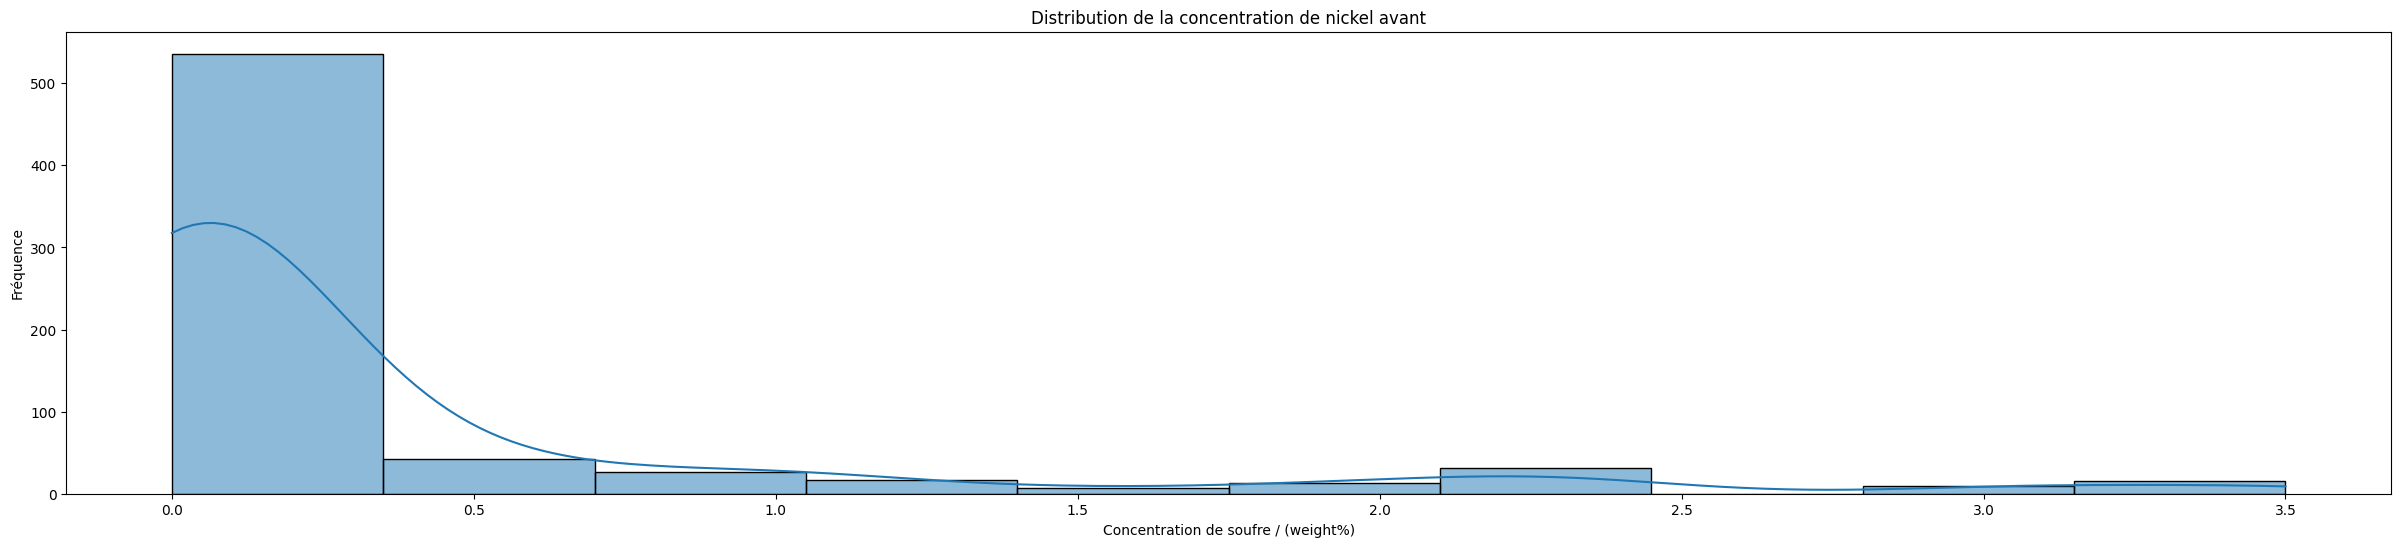

count    697.000000
mean       0.415034
std        0.786951
min        0.000000
25%        0.000000
50%        0.067000
75%        0.260000
max        3.500000
Name: Nickel concentration / (weight%), dtype: float64

In [20]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(data['Nickel concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de nickel avant')
plt.xlabel('Concentration de soufre / (weight%)')
plt.ylabel('Fréquence')
plt.show()
df['Nickel concentration / (weight%)'].describe()

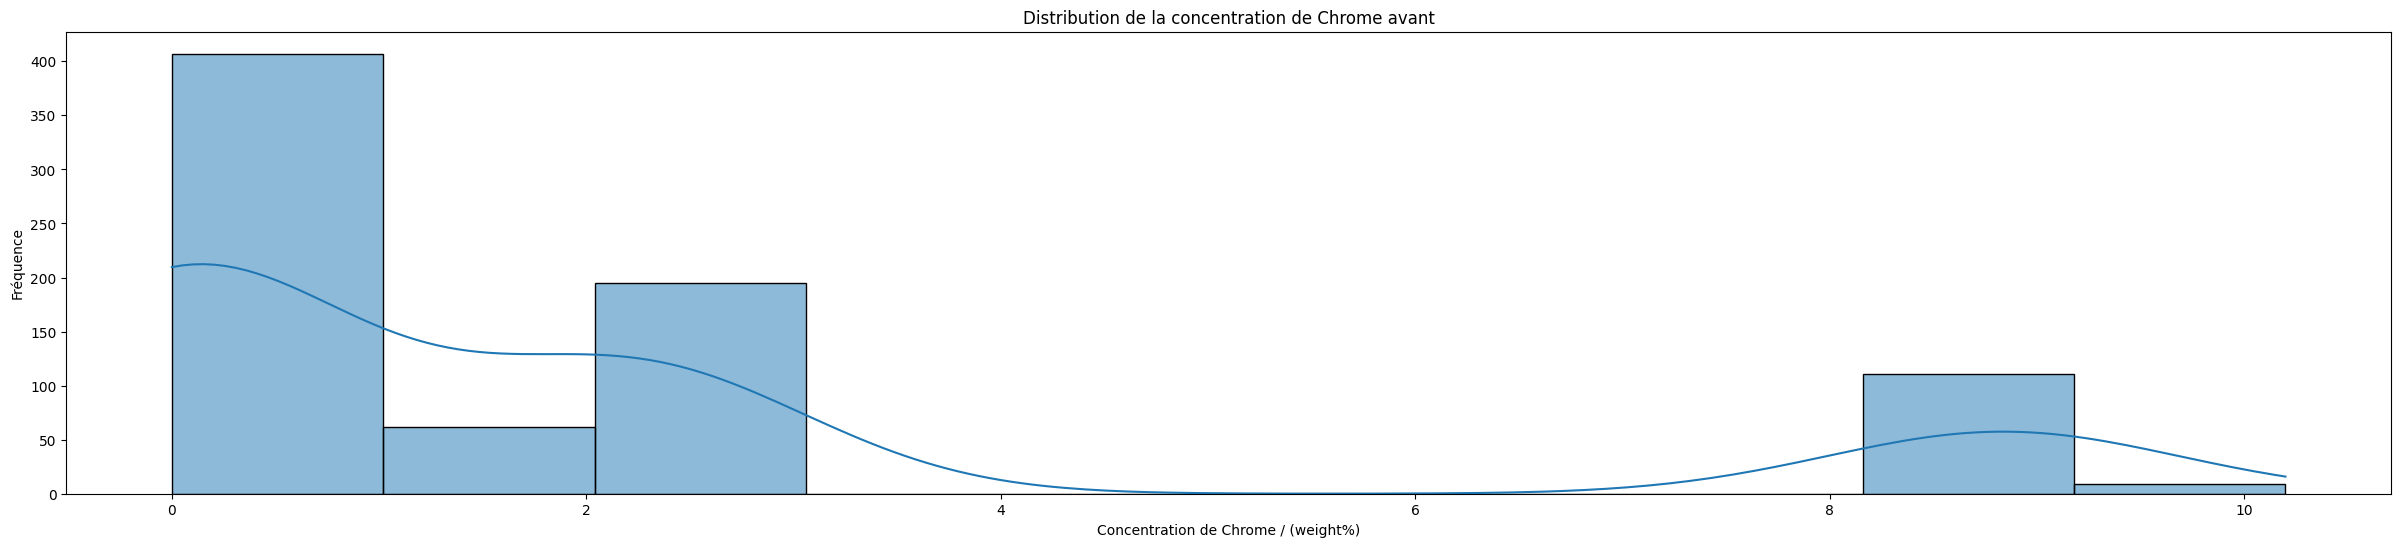

count    784.000000
mean       2.101273
std        3.026548
min        0.000000
25%        0.000000
50%        0.530000
75%        2.300000
max       10.200000
Name: Chromium concentration / (weight%), dtype: float64

In [22]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(data['Chromium concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de Chrome avant')
plt.xlabel('Concentration de Chrome / (weight%)')
plt.ylabel('Fréquence')
plt.show()
df['Chromium concentration / (weight%)'].describe()

In [24]:
df['Nickel concentration / (weight%)'].fillna(df['Nickel concentration / (weight%)'].mean(), inplace=True)
df['Chromium concentration / (weight%)'].fillna(df['Chromium concentration / (weight%)'].mean(), inplace=True)
df['Molybdenum concentration / (weight%)'].fillna(df['Molybdenum concentration / (weight%)'].mean(), inplace=True)
df['Vanadium concentration / (weight%)'].fillna(df['Vanadium concentration / (weight%)'].mean(), inplace=True)
df['Copper concentration / (weight%)'].fillna(df['Copper concentration / (weight%)'].mean(), inplace=True)
df['Cobalt concentration / (weight%)'].fillna(df['Cobalt concentration / (weight%)'].mean(), inplace=True)
df['Tungsten concentration / (weight%)'].fillna(df['Tungsten concentration / (weight%)'].mean(), inplace=True)
df['Oxygen concentration / parts per million by weight'].fillna(df['Oxygen concentration / parts per million by weight'].mean(), inplace=True)
df['Titanium concentration / parts per million by weight'].fillna(df['Titanium concentration / parts per million by weight'].mean(), inplace=True)


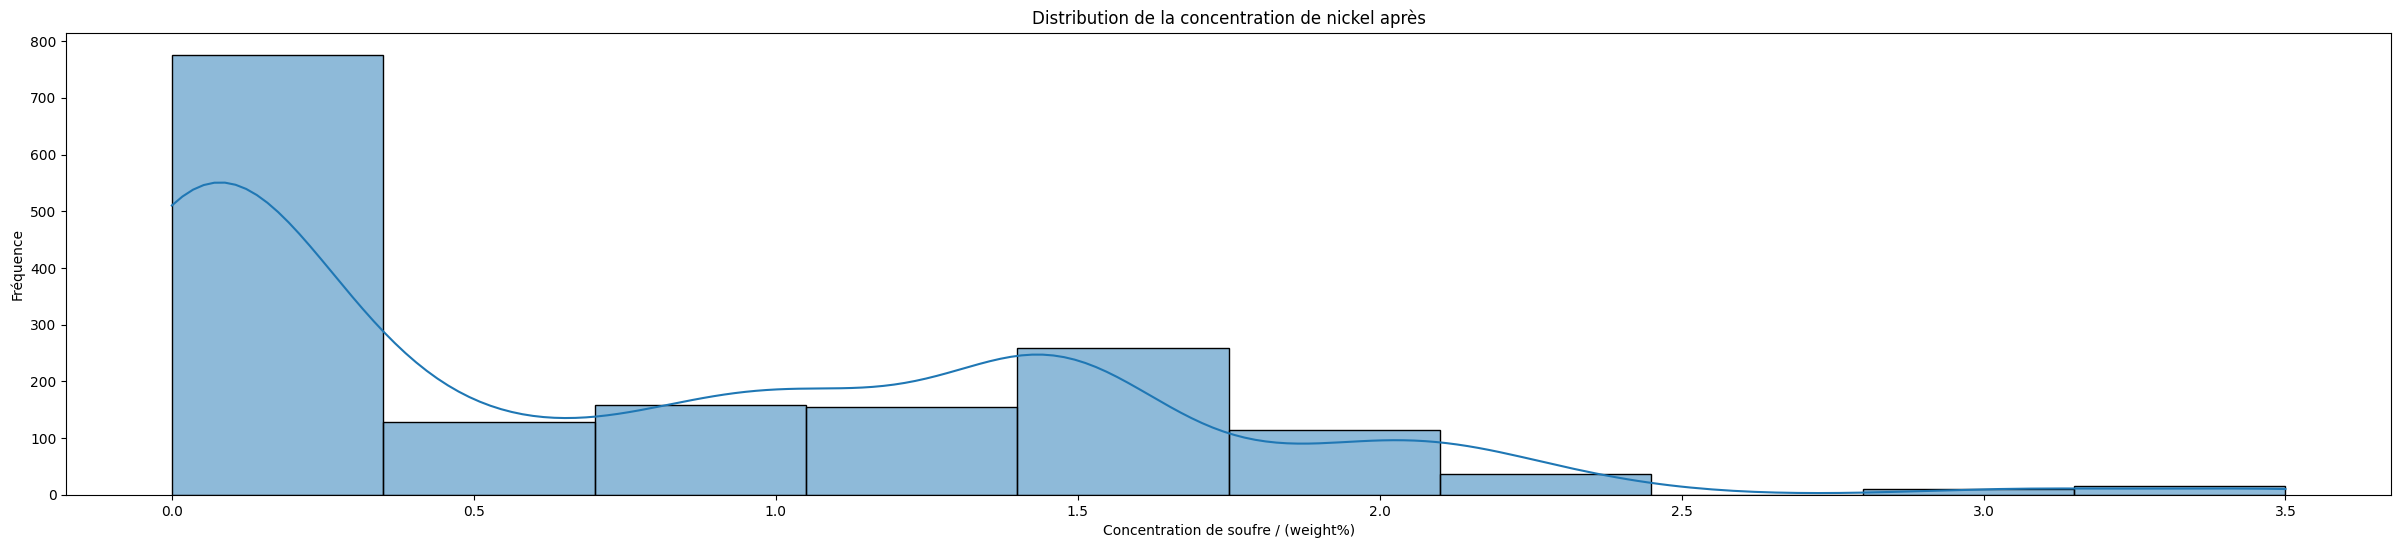

count    1652.000000
mean        0.749461
std         0.759491
min         0.000000
25%         0.056750
50%         0.468000
75%         1.444000
max         3.500000
Name: Nickel concentration / (weight%), dtype: float64

In [21]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(df_combined['Nickel concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de nickel après')
plt.xlabel('Concentration de soufre / (weight%)')
plt.ylabel('Fréquence')
plt.show()
df_combined['Nickel concentration / (weight%)'].describe()

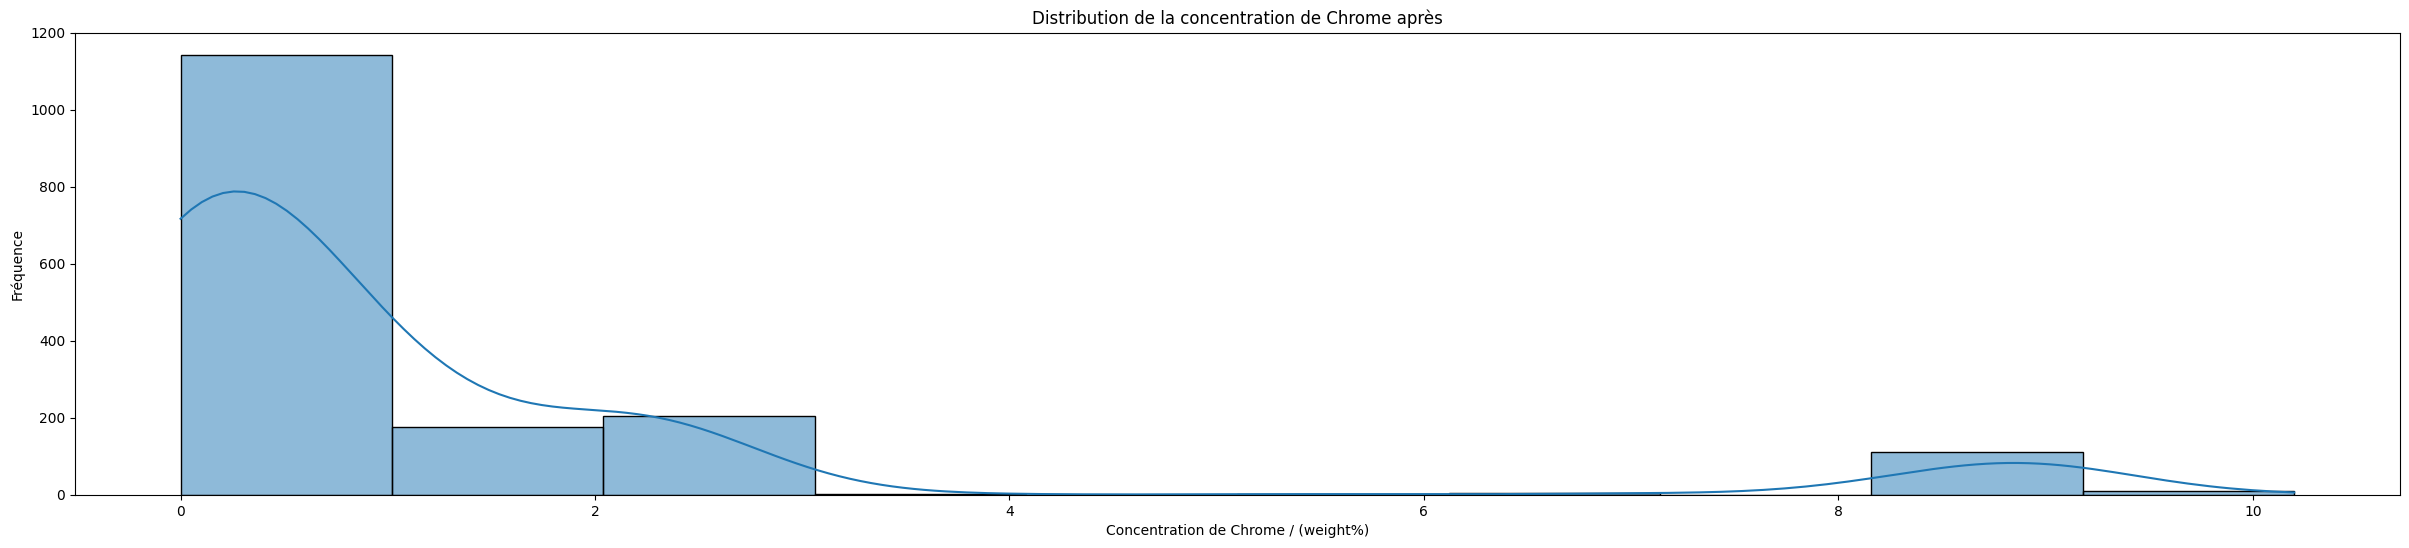

count    1652.000000
mean        1.309406
std         2.274116
min         0.000000
25%         0.050000
50%         0.468000
75%         1.339000
max        10.200000
Name: Chromium concentration / (weight%), dtype: float64

In [23]:
# Tracer le graphique de distribution
plt.figure(figsize=(30, 6))
sns.histplot(df_combined['Chromium concentration / (weight%)'], bins=10, kde=True)
plt.title('Distribution de la concentration de Chrome après')
plt.xlabel('Concentration de Chrome / (weight%)')
plt.ylabel('Fréquence')
plt.show()
df_combined['Chromium concentration / (weight%)'].describe()

### Observations sur le remplissage de valeurs

Pour le nickel, la moyenne n'a pas changé, mais la répartition des valeurs s'est décalé vers la droite

Résultat similaire pour le chrome

Au lieu d'ajouter une valeur moyenne, pourquoi pas ajouter en respectant la répartition des valeurs ????

In [ ]:
df['Nitrogen concentration / parts per million by weight'].fillna(df['Nitrogen concentration / parts per million by weight'].mean(), inplace=True)
df['Aluminium concentration / parts per million by weight'].fillna(df['Aluminium concentration / parts per million by weight'].mean(), inplace=True)
df['Boron concentration / parts per million by weight'].fillna(df['Boron concentration / parts per million by weight'].mean(), inplace=True)
df['Niobium concentration / parts per million by weight'].fillna(df['Niobium concentration / parts per million by weight'].mean(), inplace=True)
df['Tin concentration / parts per million by weight'].fillna(df['Tin concentration / parts per million by weight'].mean(), inplace=True)
df['Arsenic concentration / parts per million by weight'].fillna(df['Arsenic concentration / parts per million by weight'].mean(), inplace=True)
df['Antimony concentration / parts per million by weight'].fillna(df['Antimony concentration / parts per million by weight'].mean(), inplace=True)

In [ ]:
# Convert to numeric, coercing errors to NaN
df['Nitrogen concentration / parts per million by weight'] = pd.to_numeric(df['Nitrogen concentration / parts per million by weight'], errors='coerce')

# Optionally, drop NaN values if you want to calculate the mean only for valid entries
mean_nitrogen_concentration = df['Nitrogen concentration / parts per million by weight'].mean()
print(mean_nitrogen_concentration)

In [ ]:
df['Nitrogen concentration / parts per million by weight'].fillna(df['Nitrogen concentration / parts per million by weight'].mean(), inplace=True)
df['Aluminium concentration / parts per million by weight'].fillna(df['Aluminium concentration / parts per million by weight'].mean(), inplace=True)
df['Boron concentration / parts per million by weight'].fillna(df['Boron concentration / parts per million by weight'].mean(), inplace=True)
df['Niobium concentration / parts per million by weight'].fillna(df['Niobium concentration / parts per million by weight'].mean(), inplace=True)
df['Tin concentration / parts per million by weight'].fillna(df['Tin concentration / parts per million by weight'].mean(), inplace=True)
df['Arsenic concentration / parts per million by weight'].fillna(df['Arsenic concentration / parts per million by weight'].mean(), inplace=True)
df['Antimony concentration / parts per million by weight'].fillna(df['Antimony concentration / parts per million by weight'].mean(), inplace=True)

### III.Missing values :  current & Voltage ###

In [ ]:
df[df['Current / A'].isnull()]['Common_Prefix'].value_counts()

In [260]:
evans_c=df[df['Common_Prefix']=='Evans']['Current / A'].mean()
evans_v=df[df['Common_Prefix']=='Evans']['Voltage / V'].mean()

In [262]:
# Fill NaN values with the mean in the original DataFrame
df.loc[df['Common_Prefix'] == 'Evans', 'Current / A'] = df.loc[df['Common_Prefix'] == 'Evans', 'Current / A'].fillna(evans_c)
df.loc[df['Common_Prefix'] == 'Evans', 'Voltage / V'] = df.loc[df['Common_Prefix'] == 'Evans', 'Voltage / V'].fillna(evans_v)

In [264]:
df['Current / A']= df['Current / A'].fillna(df['Current / A'].mean())
df['Voltage / V']= df['Voltage / V'].fillna(df['Voltage / V'].mean())

### III.Missing values :  AC or DC ###

In [ ]:
df[df['AC or DC'].isnull()]['Common_Prefix'].value_counts()

In [ ]:
df[df['Common_Prefix']=='Evans']['AC or DC'].value_counts()

In [271]:
df.loc[df['Common_Prefix'] == 'Evans', 'AC or DC'] = df.loc[df['Common_Prefix'] == 'Evans', 'AC or DC'].fillna('DC')

In [273]:
df['AC or DC']= df['AC or DC'].fillna('o')

### III.Missing values :  Electrode positive ou négative ###

In [ ]:
df[df['Electrode positive or negative'].isnull()]['Common_Prefix'].value_counts()

In [ ]:
df[df['Common_Prefix']=='Evans']['Electrode positive or negative'].value_counts()

In [280]:
df['Electrode positive or negative']= df['Electrode positive or negative'].fillna('+')

### III.Missing values :  Post weld heat treatment temperature / deg C et 

Post weld heat treatment time / hours  ###

In [ ]:
df[df['Post weld heat treatment time / hours'].isnull()]['Common_Prefix'].value_counts()

In [ ]:
df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment temperature / deg C'].mean()

In [287]:
gark_t=df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment temperature / deg C'].mean()
gark_time=df[df['Common_Prefix']=='Gar&K-1975-']['Post weld heat treatment time / hours'].mean()

In [289]:
df['Post weld heat treatment temperature / deg C']= df['Post weld heat treatment temperature / deg C'].fillna(gark_t)
df['Post weld heat treatment time / hours']= df['Post weld heat treatment time / hours'].fillna(gark_time)

### III.Missing values : Charpy   ###

In [ ]:
df[df['Charpy impact toughness / J'].isnull()]['Common_Prefix'].value_counts()

In [294]:
evans_charpyJ=df[df['Common_Prefix']=='Evans']['Charpy impact toughness / J'].mean()
evanc_charpyC=df[df['Common_Prefix']=='Evans']['Charpy temperature / deg C'].mean()

In [ ]:
evans_charpyJ

In [296]:
df.loc[df['Common_Prefix'] == 'Evans', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Evans', 'Charpy impact toughness / J'].fillna(evans_charpyJ)
df.loc[df['Common_Prefix'] == 'Evans', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Evans', 'Charpy temperature / deg C'].fillna(evanc_charpyC)

In [298]:
pant_charpyJ=df[df['Common_Prefix']=='PantK-1990-']['Charpy impact toughness / J'].mean()
pant_charpyC=df[df['Common_Prefix']=='PantK-1990-']['Charpy temperature / deg C'].mean()

In [300]:
df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy impact toughness / J'].fillna(pant_charpyJ)
df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'PantK-1990-', 'Charpy temperature / deg C'].fillna(pant_charpyC)

In [302]:
sven_charpyJ=df[df['Common_Prefix']=='SvenGret-1990-']['Charpy impact toughness / J'].mean()
sven_charpyC=df[df['Common_Prefix']=='SvenGret-1990-']['Charpy temperature / deg C'].mean()

In [304]:
df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy impact toughness / J'].fillna(sven_charpyJ)
df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'SvenGret-1990-', 'Charpy temperature / deg C'].fillna(sven_charpyC)

In [306]:
pat_charpyJ=df[df['Common_Prefix']=='Pat-1981-']['Charpy impact toughness / J'].mean()
pat_charpyC=df[df['Common_Prefix']=='Pat-1981-']['Charpy temperature / deg C'].mean()

In [308]:
df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy impact toughness / J'].fillna(pat_charpyJ)
df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Pat-1981-', 'Charpy temperature / deg C'].fillna(pat_charpyC)

In [ ]:
df[df['Common_Prefix']=='EvHtIp1979-']['Charpy impact toughness / J'].mean()

In [312]:
evht_charpyJ=df[df['Common_Prefix']=='EvHtIp1979-']['Charpy impact toughness / J'].mean()
evht_charpyC=df[df['Common_Prefix']=='EvHtIp1979-']['Charpy temperature / deg C'].mean()

In [314]:
df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy impact toughness / J'].fillna(evht_charpyJ)
df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'EvHtIp1979-', 'Charpy temperature / deg C'].fillna(evht_charpyC)

In [ ]:
df[df['Common_Prefix']=='Icici&-1992-']['Charpy impact toughness / J'].mean()

In [318]:
ici_charpyJ=df[df['Common_Prefix']=='Icici&-1992-']['Charpy impact toughness / J'].mean()
ici_charpyC=df[df['Common_Prefix']=='Icici&-1992-']['Charpy temperature / deg C'].mean()

In [320]:
df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy impact toughness / J'].fillna(ici_charpyJ)
df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Icici&-1992-', 'Charpy temperature / deg C'].fillna(ici_charpyC)

In [ ]:
df[df['Common_Prefix']=='Blond&-1984-']['Charpy impact toughness / J'].mean()

In [324]:
bld_charpyJ=df[df['Common_Prefix']=='Blond&-1984-']['Charpy impact toughness / J'].mean()
bld_charpyC=df[df['Common_Prefix']=='Blond&-1984-']['Charpy temperature / deg C'].mean()

In [326]:
df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy impact toughness / J'].fillna(bld_charpyJ)
df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Blond&-1984-', 'Charpy temperature / deg C'].fillna(bld_charpyC)

In [ ]:
df[df['Common_Prefix']=='Mart-']['Charpy impact toughness / J'].mean()

In [330]:
mrt_charpyJ=df[df['Common_Prefix']=='Mart-']['Charpy impact toughness / J'].mean()
mrt_charpyC=df[df['Common_Prefix']=='Mart-']['Charpy temperature / deg C'].mean()

In [332]:
df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy impact toughness / J'].fillna(mrt_charpyJ)
df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Mart-', 'Charpy temperature / deg C'].fillna(mrt_charpyC)

In [ ]:
df[df['Common_Prefix']=='Ditt-']['Charpy impact toughness / J'].mean()

In [335]:
ditt_charpyJ=df[df['Common_Prefix']=='Ditt-']['Charpy impact toughness / J'].mean()
ditt_charpyC=df[df['Common_Prefix']=='Ditt-']['Charpy temperature / deg C'].mean()

In [338]:
df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy impact toughness / J'].fillna(ditt_charpyJ)
df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Ditt-', 'Charpy temperature / deg C'].fillna(ditt_charpyC)

In [ ]:
df[df['Common_Prefix']=='Chandel&-1985W']['Charpy impact toughness / J'].mean()

In [342]:
chdl_charpyJ=df[df['Common_Prefix']=='Chandel&-1985W']['Charpy impact toughness / J'].mean()
chdl_charpyC=df[df['Common_Prefix']=='Chandel&-1985W']['Charpy temperature / deg C'].mean()

In [344]:
df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy impact toughness / J'] = df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy impact toughness / J'].fillna(chdl_charpyJ)
df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy temperature / deg C'] = df.loc[df['Common_Prefix'] == 'Chandel&-1985W', 'Charpy temperature / deg C'].fillna(chdl_charpyC)

In [346]:
df['Charpy impact toughness / J'] = df['Charpy impact toughness / J'].fillna(df['Charpy impact toughness / J'].mean())
df['Charpy temperature / deg C'] = df['Charpy temperature / deg C'].fillna(df['Charpy temperature / deg C'].mean())

### III. Missing Values: features to delete ###

In [349]:
#50 % FATT                                                1621
#Primary ferrite in microstructure / %                    1554
#Ferrite with second phase / %                            1562
#Acicular ferrite / %                                     1562
#Martensite / %                                           1563
#Ferrite with carbide aggregate / %                       1563

In [351]:
df = df.drop(columns=['50 % FATT', 'Primary ferrite in microstructure / %', 'Ferrite with second phase / %', 'Acicular ferrite / %','Martensite / %','Ferrite with carbide aggregate / %'])

In [ ]:
df

### III.Missing values: Résumé ###

In [ ]:
df.isnull().sum()

# Les variables cibles : 

- **Yield strength** / MPa
- **Ultimate tensile strength** / MPa
- **Elongation** / %
- **Reduction of Area** / %
- **Hardness** / kg/mm²


## IV. Variables Catégoriques ##

### IV. Variables Catégoriques : Introduction

In [ ]:
df.columns

In [397]:
#  'AC or DC'
# 'Electrode positive or negative'
# 'Type of weld'
# Sont des variables catégoriques

### IV. Variables Catégoriques : AC or DC

In [ ]:
df['AC or DC'].value_counts()

In [406]:
df_encoded_1 = pd.get_dummies(df, columns=['AC or DC'])

In [ ]:
df_encoded_1.columns

In [412]:
df_encoded_1.drop(columns=['AC or DC_o'],inplace=True)

### IV. Variables Catégoriques : 'Electrode positive or negative'

In [ ]:
df['Electrode positive or negative'].value_counts()

In [423]:
df_encoded_2 = pd.get_dummies(df_encoded_1, columns=['Electrode positive or negative'])

In [ ]:
df_encoded_2.columns

In [427]:
df_encoded_2.drop(columns=['Electrode positive or negative_-'],inplace=True)

### IV. Variables Catégoriques : 'Type of Weld'

In [ ]:
df['Type of weld'].value_counts()

In [435]:
df_encoded = pd.get_dummies(df_encoded_2, columns=['Type of weld'])

In [ ]:
df_encoded.columns

In [439]:
df_encoded.drop(columns=['Type of weld_GMAA'],inplace=True)

## V. Analyse des composantes principales: ACP

### V. ACP : drop les variables cibles

In [ ]:
df_encoded.columns

In [482]:
X=df_encoded[['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'Heat input / kJ/mm', 'Interpass temperature / deg C',
       'Post weld heat treatment temperature / deg C',
       'Post weld heat treatment time / hours' , 'Charpy temperature / deg C',
       'Charpy impact toughness / J',
        'AC or DC_AC', 'AC or DC_DC',
       'Electrode positive or negative_+', 'Electrode positive or negative_0',
       'Type of weld_FCA', 'Type of weld_GTAA', 'Type of weld_MMA',
       'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA',
       'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']]

In [484]:
y=df_encoded[['Yield strength / MPa',
       'Ultimate tensile strength / MPa', 'Elongation / %',
       'Reduction of Area / %','Hardness / kg/mm2']]

### V. ACP : standardisation

In [ ]:
def replace_range_with_avg(value):
    if isinstance(value, str) and '-' in value:
        try:
            # Séparer les deux nombres et calculer la moyenne
            numbers = list(map(float, value.split('-')))
            return sum(numbers) / len(numbers)
        except ValueError:
            return value  # Si ce n'est pas un format attendu, garder la valeur originale
    else:
        return value  # Si ce n'est pas une chaîne au format '150-200', garder la valeur originale

# Appliquer la fonction sur toutes les colonnes du DataFrame
X = X.applymap(replace_range_with_avg)


In [501]:
# Standardisation des données (important pour la PCA)
scaler = StandardScaler()
X_scaled_28 = scaler.fit_transform(X[['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'Heat input / kJ/mm', 'Interpass temperature / deg C',
       'Post weld heat treatment temperature / deg C',
       'Post weld heat treatment time / hours' , 'Charpy temperature / deg C',
       'Charpy impact toughness / J']])

In [503]:
X[['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per million by weight',
       'Antimony concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'Heat input / kJ/mm', 'Interpass temperature / deg C',
       'Post weld heat treatment temperature / deg C',
       'Post weld heat treatment time / hours' , 'Charpy temperature / deg C',
       'Charpy impact toughness / J']]=X_scaled_28

### V. ACP : Choix du nombre de composants

In [ ]:
# Appliquer la PCA
pca = PCA()  # Laisser scikit-learn décider du nombre maximal de composantes
pca.fit(X)

# Variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Calcul de la variance cumulée
explained_variance_cumulative = np.cumsum(explained_variance_ratio)

# Tracer le graphe
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='', linestyle='-')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes principales')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()

In [519]:
# 25 composantes peut expliquer plus de 90% des données

### V. ACP

In [ ]:
# Appliquer la PCA
pca = PCA(n_components=25)  # Laisser scikit-learn décider du nombre maximal de composantes
pca.fit(X)
pca_result = pca.transform(X)
# Créer un DataFrame pour les résultats de la PCA
pca_X = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 
 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 
 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25'])

# Afficher les résultats
pca_X

In [ ]:
print("Variance expliquée cumulée par chaque composante :", pca.explained_variance_ratio_.sum())